### Neural Networks to fit $(x, y) = (\cos(\theta), \sin(\theta))$ and $\theta = \arctan2(x, y)$

In [1]:
# Library imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time

# Aliases
keras = tf.keras

In [2]:
# Local imports
from utils import gpu_grow_memory, TimeHistory, EpochLoss, plot_loss_hist
from utils import load_vartbl, save_vartbl, plot_style

from polar_coord import make_data_circle, make_dataset_circle
from polar_coord import make_models_circle_math, make_model_circle_p2c
from polar_coord import compile_and_fit, make_model_autoencoder

In [3]:
# Grow GPU memory (must be first operation in TF)
gpu_grow_memory()

In [4]:
# Plot style 
plot_style()

In [5]:
# Lightweight serialization
fname = '../pickle/polar_coord.pickle'
vartbl = load_vartbl(fname)

## Create datasets for $\theta \in [-\pi, \pi]$ and $x, y \in [-1, 1]$

In [6]:
# Make datasets for circle
n = 36000
data_circle = make_data_circle(n)
ds_p2c, ds_c2p, ds_p2p, ds_c2c = make_dataset_circle(n=n, batch_size=3600)

In [8]:
# Set number of epochs
epoch_size = n
epochs = (20000 * 3600) // n
samples_total = epochs * epoch_size

# Set save_freq in terms of SAMPLES
save_freq = samples_total // 10

# Print summary
print(f'Built data set with n={n:,}.')
print(f'Training for {epochs} epochs total, with {samples_total:,} sample points total.')
print(f'Save frequency every {save_freq:,} samples.')

Built data set with n=36,000.
Training for 2000 epochs total, with 72,000,000 sample points total.
Save frequency every 7,200,000 samples.


In [9]:
# # Unpack one example batch
# batch_theta, batch_x = list(ds_p2c.take(10))[0]
# batch_theta, batch_x = batch_theta.numpy(), batch_x.numpy()

# # Review data contents
# print(f'batch size: {batch_theta.shape[0]}')
# print(f'theta: min={np.min(batch_theta):+8.5}, max={np.max(batch_theta):+8.5}')
# print(f'    x: min={np.min(batch_x):+8.5}, max={np.max(batch_x):+8.5}')

In [10]:
theta = data_circle['theta']
x = data_circle['x']
y = data_circle['y']

## Deterministic Mathematical Models

In [11]:
# Mathematical models
math_p2c, math_c2p, math_p2p, math_c2c = make_models_circle_math()

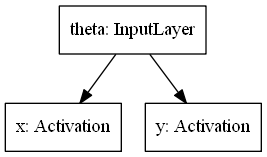

In [12]:
keras.utils.plot_model(math_p2c)

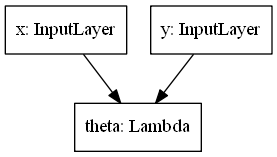

In [13]:
keras.utils.plot_model(math_c2p)

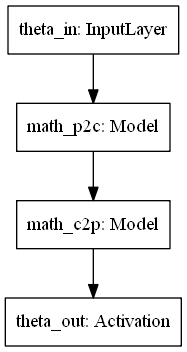

In [14]:
keras.utils.plot_model(math_p2p)

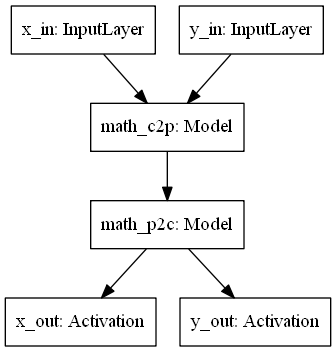

In [15]:
keras.utils.plot_model(math_c2c)

In [16]:
math_p2c.summary()

Model: "math_p2c"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
theta (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
x (Activation)                  (None, 1)            0           theta[0][0]                      
__________________________________________________________________________________________________
y (Activation)                  (None, 1)            0           theta[0][0]                      
Total params: 0
Trainable params: 0
Non-trainable params: 0
__________________________________________________________________________________________________


In [17]:
# Set loss function and optimizer
loss = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam()
metrics = [keras.metrics.MeanAbsoluteError()]

In [18]:
# Compile the math models
math_p2c.compile(loss=loss, optimizer=optimizer, metrics=metrics)
math_c2p.compile(loss=loss, optimizer=optimizer, metrics=metrics)
math_p2p.compile(loss=loss, optimizer=optimizer, metrics=metrics)
math_c2c.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [19]:
# Evaluate the p2c math model
# math_p2c.evaluate(theta, x)
math_p2c.evaluate(ds_p2c)

10/10 [==============================] - 0s 24ms/step - loss: 7.1612e-16 - x_loss: 3.7961e-16 - y_loss: 3.3651e-16 - x_mean_absolute_error: 7.6335e-09 - y_mean_absolute_error: 6.0855e-09


[7.161216388578519e-16, 3.7961065e-16, 3.36511e-16, 7.633493e-09, 6.085543e-09]

In [20]:
# Evaluate the c2p math model
# math_c2p.evaluate(x, theta)
math_c2p.evaluate(ds_c2p)

10/10 [==============================] - 0s 18ms/step - loss: 2.2487e-15 - mean_absolute_error: 1.5681e-08


[2.2486744386570995e-15, 1.5681021e-08]

In [21]:
# Evaluate the c2c math model
math_c2c.evaluate(ds_c2c)

10/10 [==============================] - 0s 33ms/step - loss: 2.5067e-15 - x_out_loss: 1.3062e-15 - y_out_loss: 1.2005e-15 - x_out_mean_absolute_error: 1.6146e-08 - y_out_mean_absolute_error: 1.3262e-08


[2.506696513906873e-15,
 1.3061658e-15,
 1.2005307e-15,
 1.6146195e-08,
 1.3261726e-08]

In [22]:
# Evaluate the p2p math model
math_p2p.evaluate(ds_p2p)

10/10 [==============================] - 0s 14ms/step - loss: 1.5395e-15 - mean_absolute_error: 1.2495e-08


[1.5394645833548867e-15, 1.2494802e-08]

## Functions for visualizing neural network outputs $x = \cos(\theta)$

In [66]:
def plot_pred_xy(model, theta):
    # Predictions of the model
    x_pred, y_pred = model.predict(theta)
    x_pred = x_pred.reshape((-1,))
    y_pred = y_pred.reshape((-1,))
    
    # Plot predictions
    fig, ax = plt.subplots(figsize=[16,9])
    ax.set_title(f'$(x, y) = (\\cos(\\theta), \\sin(\\theta))$ in {model.name}')
    ax.set_xlabel('$\\theta$')
    ax.set_ylabel('$x$ and $y$')
    ax.set_xlim(-np.pi, np.pi)
    ax.set_xticks(np.linspace(-np.pi, np.pi, 9))
    ax.set_xticklabels(['$-\pi$', '-$3\pi/4$', '-$\pi/2$', '$-\pi/4$' ,
                        '$0$', '$\pi/4$', '$\pi/2$', '$3\pi/4$', '$\pi$'])
    ax.set_ylim(-1.05, 1.05)
    ax.set_yticks(np.linspace(-1.0, 1.0, 9))
    ax.plot(theta, x, color='blue', label='$\cos(\\theta)$', linewidth=4.0)
    ax.plot(theta, x_pred, color='red', label='NN_x$(\\theta)$', linewidth=2.0)
    ax.plot(theta, y, color='green', label='$\sin(\\theta)$', linewidth=4.0)
    ax.plot(theta, y_pred, color='orange', label='NN_y$(\\theta)$', linewidth=2.0)
    ax.grid()
    ax.legend()
    return fig, ax

In [72]:
def plot_error_xy(model, theta):
    # Predictions of the model
    x_pred, y_pred = model.predict(theta)
    x_pred = x_pred.reshape((-1,))
    y_pred = y_pred.reshape((-1,))
    
    # Errors
    x_error = x_pred - np.cos(theta)
    y_error = y_pred - np.sin(theta)
    
    # Plot errors
    fig, ax = plt.subplots(figsize=[16,9])
    ax.set_title(f'Error for $(x, y) = (\\cos(\\theta), \\sin(\\theta))$ in {model.name}')
    ax.set_xlabel('$\\theta$')
    ax.set_ylabel('$x$ and $y$')
    ax.set_xlim(-np.pi, np.pi)
    ax.set_xticks(np.linspace(-np.pi, np.pi, 9))
    ax.set_xticklabels(['$-\pi$', '-$3\pi/4$', '-$\pi/2$', '$-\pi/4$' ,
                        '$0$', '$\pi/4$', '$\pi/2$', '$3\pi/4$', '$\pi$'])
    ax.plot(theta, x_error, color='red',  label='error_x', linewidth=4.0)
    ax.plot(theta, y_error, color='blue', label='error_y', linewidth=4.0)
    ax.grid()
    ax.legend()
    return fig, ax

## Neural networks for $x = \cos(\theta)$

### Network Design 0: [ ]
model_circle_p2c has only feature augmentation layers with powers of theta up to 8

In [57]:
def make_model_circle_p2c(powers, hidden_sizes, skip_layers):
    """
    Neural net model from theta to (x, y)
    INPUTS:
        powers: list of integer powers of the input in feature augmentation
        hidden_sizes: sizes of up to 2 hidden layers
        skip_layers: whether to include skip layers (copy of previous features)
    """
    # Input layer
    theta = keras.Input(shape=(1,), name='theta')

    # Number of hidden layers
    num_layers = len(hidden_sizes)

    # Feature augmentation; the selected powers
    theta_ps = []
    for p in powers:
        theta_p = keras.layers.Lambda(lambda z: tf.pow(z, p) / tf.exp(tf.math.lgamma(p+1.0)), name=f'theta_{p}')(theta)
        theta_ps.append(theta_p)
    
    # Augmented feature layer
    phi_0 = keras.layers.concatenate(inputs=theta_ps, name='phi_0')
    phi_n = phi_0

    # Dense feature layers
    
    # First hidden layer if applicable
    if num_layers > 0:
        phi_1 = keras.layers.Dense(units=hidden_sizes[0], activation='tanh', name='phi_1')(phi_0)
        if skip_layers:
            phi_1 = keras.layers.concatenate(inputs=[phi_0, phi_1], name='phi_1_aug')
        phi_n = phi_1

    # Second hidden layer if applicable
    if num_layers > 1:
        phi_2 = keras.layers.Dense(units=hidden_sizes[1], activation='tanh', name='phi_2')(phi_1)
        if skip_layers:
            phi_2 = keras.layers.concatenate(inputs=[phi_1, phi_2], name='phi_2_aug')
        phi_n = phi_2

    # Output layers
    x = keras.layers.Dense(units=1, name='x')(phi_n)
    y = keras.layers.Dense(units=1, name='y')(phi_n)

    # Wrap into a model
    model_name = f'model_circle_p2c_' + str(hidden_sizes)
    model = keras.Model(inputs=theta, outputs=[x, y], name=model_name) 
    return model

In [76]:
# Build the NN model of (x,y) = f(theta)
model_circle_p2c_ = make_model_circle_p2c(
    powers=[1,2,3,4,5,6,7,8],
    skip_layers=False,
    hidden_sizes=[])

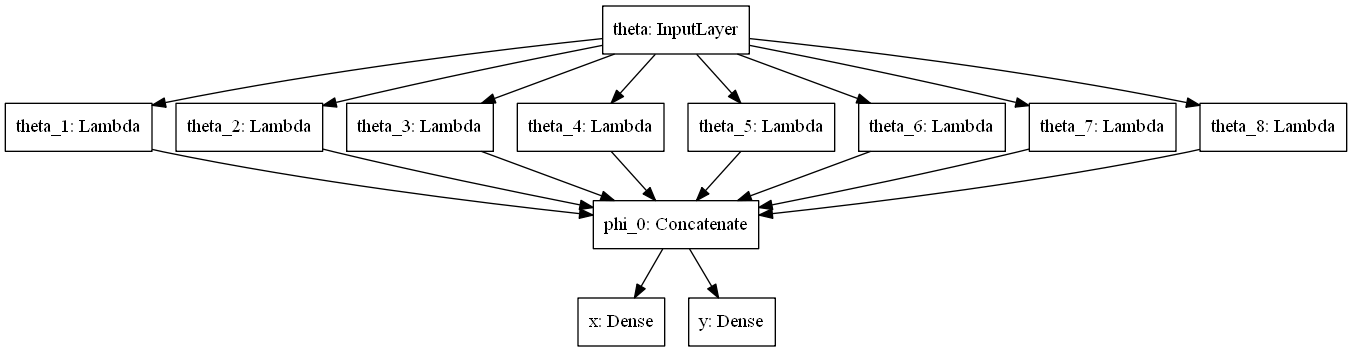

In [77]:
keras.utils.plot_model(model_circle_p2c_, show_shapes=False)

In [78]:
model_circle_p2c_.summary()

Model: "model_circle_p2c_[]"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
theta (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
theta_1 (Lambda)                (None, 1)            0           theta[0][0]                      
__________________________________________________________________________________________________
theta_2 (Lambda)                (None, 1)            0           theta[0][0]                      
__________________________________________________________________________________________________
theta_3 (Lambda)                (None, 1)            0           theta[0][0]                      
________________________________________________________________________________

In [79]:
loss=keras.losses.MeanSquaredError()
optimizer=keras.optimizers.Adam(learning_rate=1.0E-3)

try:
    model_circle_p2c_.load_weights('../models/polar/model_circle_p2c_[].h5')
    model_circle_p2c_.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    hist_circle_p2c_ = vartbl['hist_circle_p2c_']
    print('Loaded model_circle_p2c_.')
except:
    hist = compile_and_fit(model=model_circle_p2c_, 
                           ds=ds_p2c, 
                           epochs=epochs,
                           loss=loss, 
                           optimizer=optimizer,
                           metrics=metrics,
                           save_freq=save_freq)
    hist_circle_p2c_ = hist.history
    vartbl['hist_circle_p2c_'] = hist_circle_p2c_
    save_vartbl(vartbl, fname)

Loaded model_circle_p2c_.


In [62]:
model_circle_p2c_.evaluate(ds_p2c)

10/10 [==============================] - 0s 33ms/step - loss: 1.9589e-05 - x_loss: 4.9023e-06 - y_loss: 1.4686e-05 - x_mean_absolute_error: 0.0019 - y_mean_absolute_error: 0.0031


[1.9588714349083602e-05,
 4.9023074e-06,
 1.4686407e-05,
 0.0019248778,
 0.0030548943]

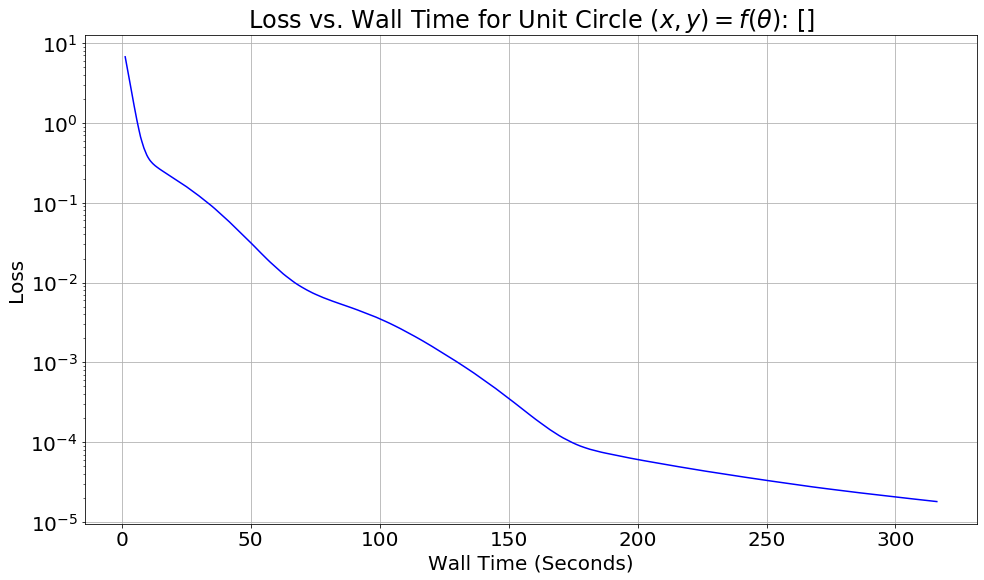

In [63]:
fig, ax = plot_loss_hist(hist_circle_p2c_, 'Unit Circle $(x, y) = f(\\theta)$: []')

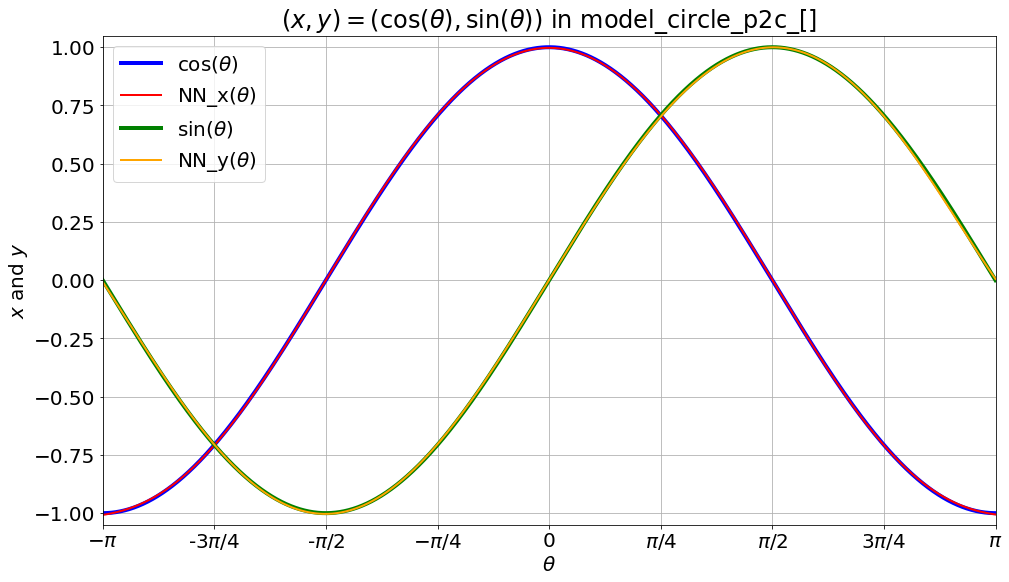

In [69]:
fig, ax = plot_pred_xy(model_circle_p2c_, theta)

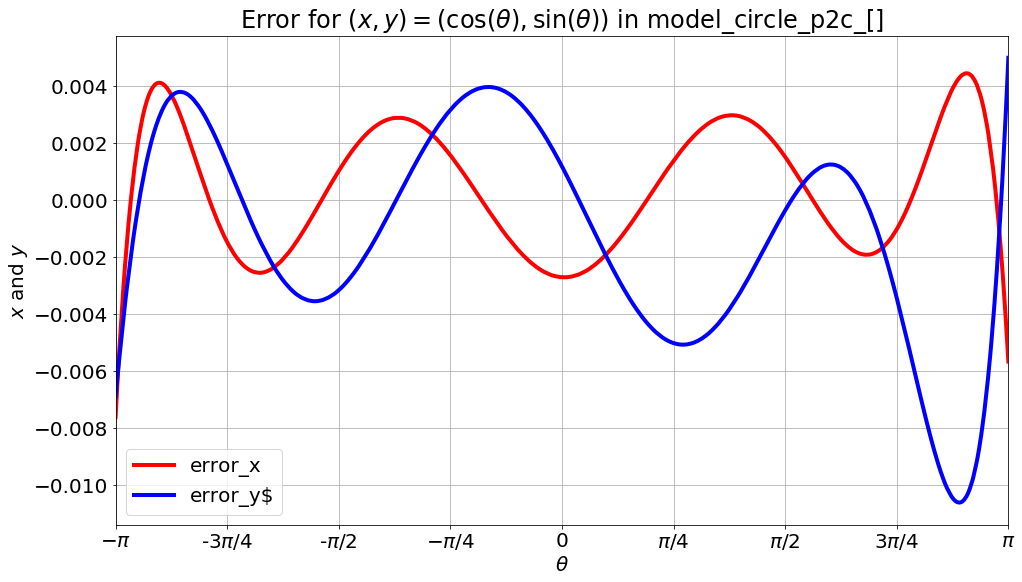

In [73]:
fig, ax = plot_error_xy(model_circle_p2c_, theta)

### Network Design 1: [64]
(model_cos_64 has one layer with 64 hidden units)

In [81]:
# Build the NN model of (x,y) = f(theta)
model_circle_p2c_64 = make_model_circle_p2c(
    powers=[1,2,3,4,5,6,7,8],
    skip_layers=True,
    hidden_sizes=[64])

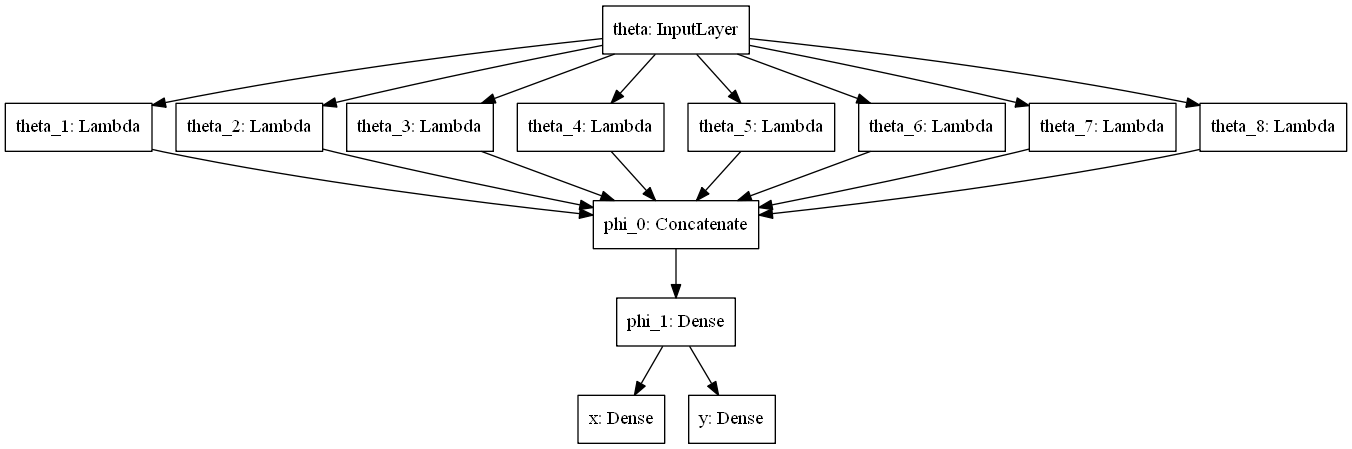

In [82]:
keras.utils.plot_model(model_circle_p2c_64, show_shapes=False)

In [83]:
model_circle_p2c_64.summary()

Model: "model_circle_p2c_[64]"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
theta (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
theta_1 (Lambda)                (None, 1)            0           theta[0][0]                      
__________________________________________________________________________________________________
theta_2 (Lambda)                (None, 1)            0           theta[0][0]                      
__________________________________________________________________________________________________
theta_3 (Lambda)                (None, 1)            0           theta[0][0]                      
______________________________________________________________________________

**Load the network and its loss history if available; otherwise train it**

In [84]:
loss=keras.losses.MeanSquaredError()
optimizer=keras.optimizers.Adam(learning_rate=1.0E-3)

try:
    model_circle_p2c_64.load_weights('../models/polar/model_circle_p2c_64[].h5')
    model_circle_p2c_64.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    hist_circle_p2c_64 = vartbl['hist_circle_p2c_64']
    print('Loaded model_circle_p2c_.')
except:
    hist = compile_and_fit(model=model_circle_p2c_64, 
                           ds=ds_p2c, 
                           epochs=epochs,
                           loss=loss, 
                           optimizer=optimizer,
                           metrics=metrics,
                           save_freq=save_freq)
    hist_circle_p2c_64 = hist.history
    vartbl['hist_circle_p2c_64'] = hist_circle_p2c_64
    save_vartbl(vartbl, fname)

Epoch 0001; loss 6.10e-01; elapsed 0:00:01
Epoch 0100; loss 1.38e-04; elapsed 0:00:16
Epoch 0200; loss 3.14e-05; elapsed 0:00:32
Epoch 0300; loss 1.37e-05; elapsed 0:00:47
Epoch 0400; loss 8.63e-06; elapsed 0:01:03
Epoch 0500; loss 8.19e-06; elapsed 0:01:18
Epoch 0600; loss 5.70e-06; elapsed 0:01:33
Epoch 0700; loss 3.83e-06; elapsed 0:01:49
Epoch 0800; loss 2.43e-06; elapsed 0:02:04
Epoch 0900; loss 4.21e-06; elapsed 0:02:19
Epoch 1000; loss 4.57e-06; elapsed 0:02:34
Epoch 1100; loss 7.98e-06; elapsed 0:02:50
Epoch 1200; loss 1.41e-06; elapsed 0:03:05
Epoch 1300; loss 8.30e-06; elapsed 0:03:20
Epoch 1400; loss 4.79e-06; elapsed 0:03:35
Epoch 1500; loss 1.97e-06; elapsed 0:03:50
Epoch 1600; loss 5.79e-07; elapsed 0:04:05
Epoch 1700; loss 1.41e-05; elapsed 0:04:20
Epoch 1800; loss 1.07e-05; elapsed 0:04:35
Restoring model weights from the end of the best epoch.
Epoch 01875: early stopping


In [85]:
model_circle_p2c_64.evaluate(ds_p2c)

10/10 [==============================] - 0s 31ms/step - loss: 7.6479e-07 - x_loss: 4.4602e-07 - y_loss: 3.1877e-07 - x_mean_absolute_error: 5.0493e-04 - y_mean_absolute_error: 4.9098e-04


[7.647947938949074e-07, 4.4601984e-07, 3.18775e-07, 0.0005049305, 0.0004909789]

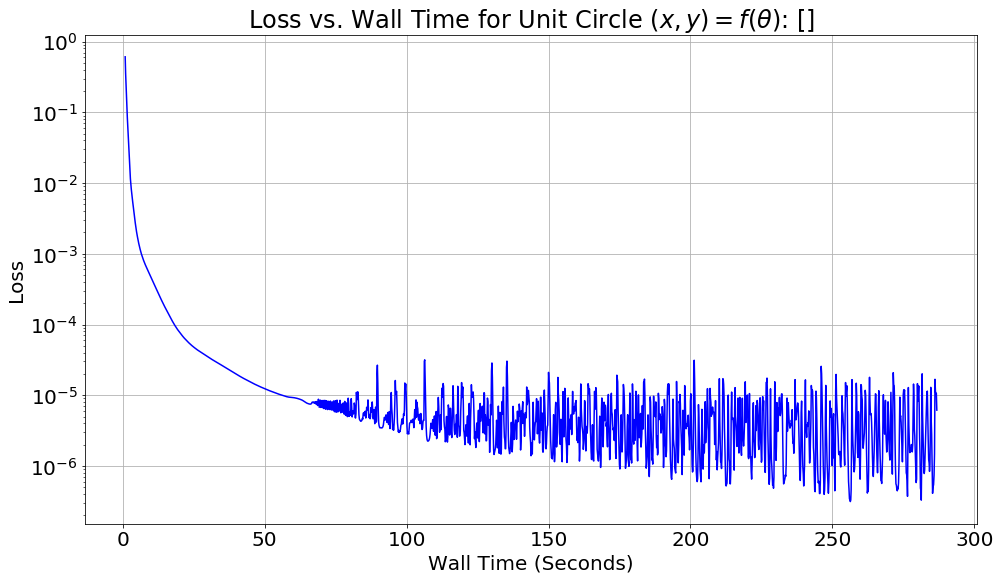

In [86]:
fig, ax = plot_loss_hist(hist_circle_p2c_64, 'Unit Circle $(x, y) = f(\\theta)$: []')

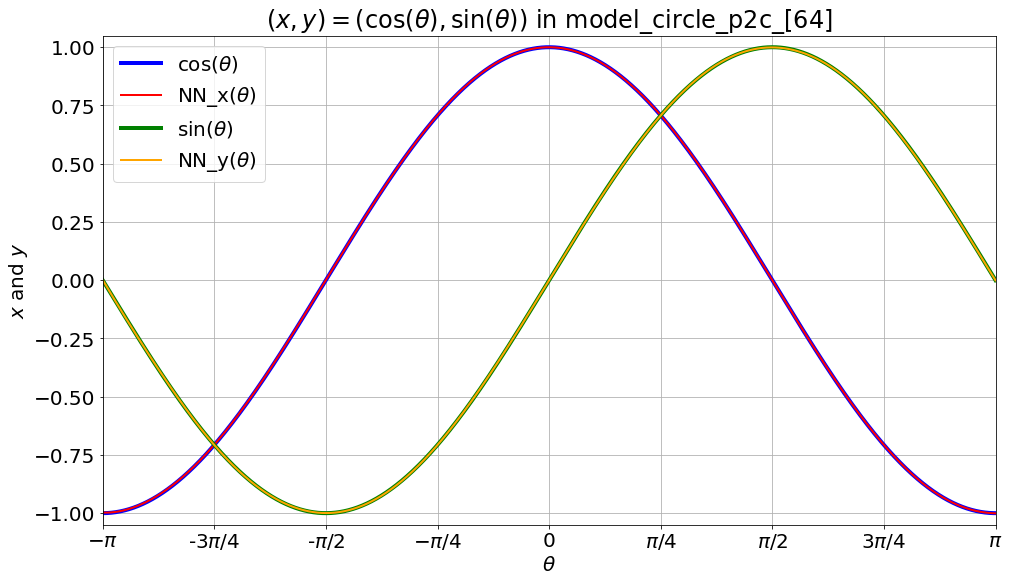

In [87]:
fig, ax = plot_pred_xy(model_circle_p2c_64, theta)

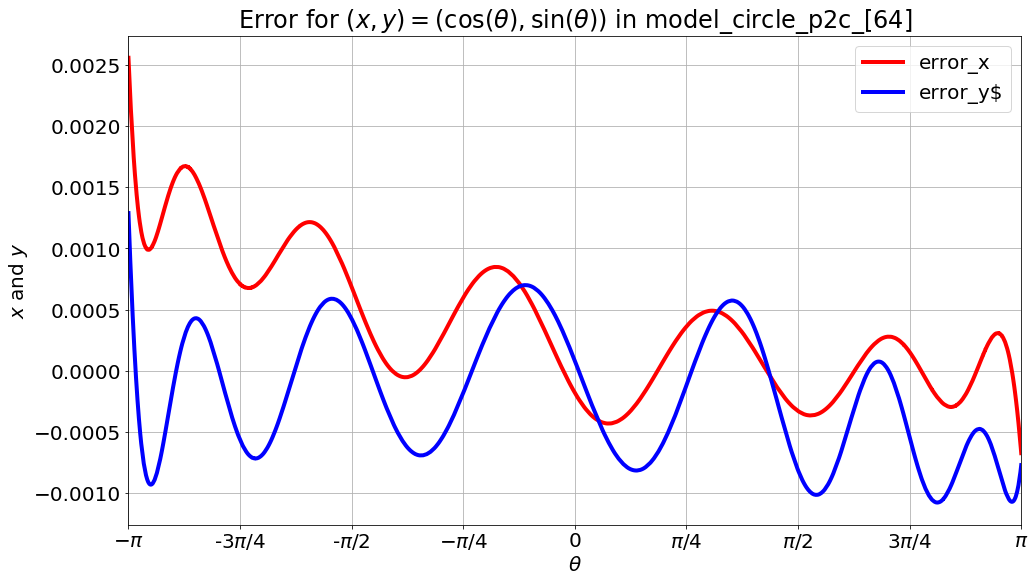

In [88]:
fig, ax = plot_error_xy(model_circle_p2c_64, theta)

### Network Design 2: [16, 16]
(model_cos_16_16 has two layers with 16 hidden units each)

In [89]:
# Build the NN model of (x,y) = f(theta)
model_circle_p2c_16_16 = make_model_circle_p2c(
    powers=[1,2,3,4,5,6,7,8],
    skip_layers=True,
    hidden_sizes=[16, 16])

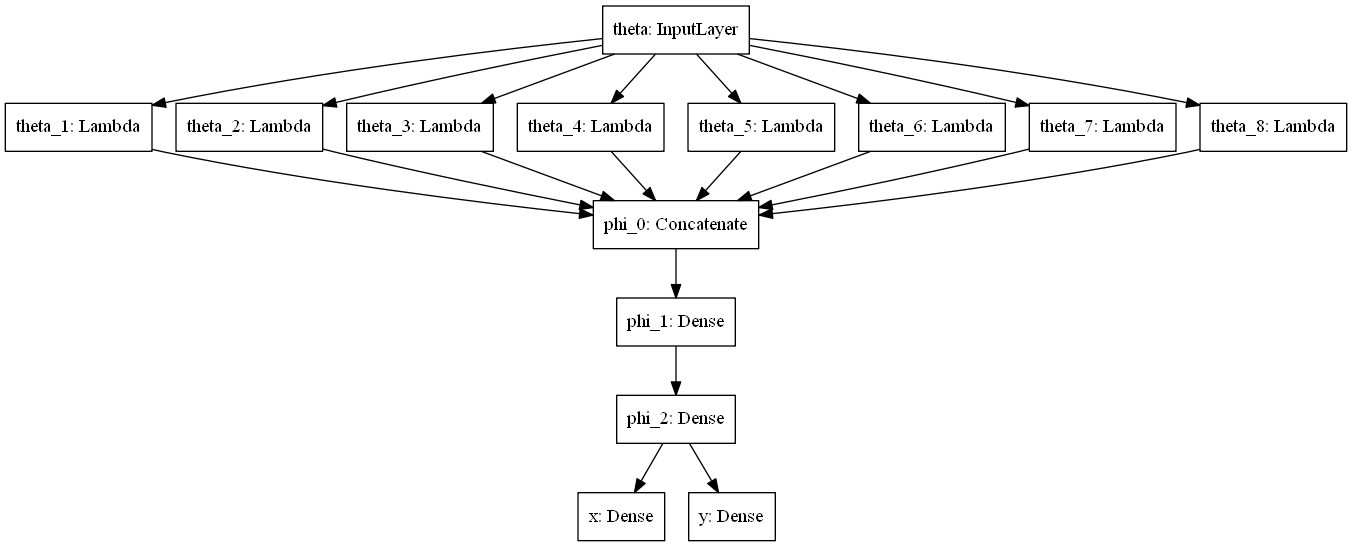

In [90]:
keras.utils.plot_model(model_circle_p2c_16_16)

In [ ]:
model_circle_p2c_16_16.summary()

**Load the network and its loss history if available; otherwise train it**

In [ ]:
loss=keras.losses.MeanSquaredError()
optimizer=keras.optimizers.Adam(learning_rate=1.0E-3)

try:
    model_circle_p2c_16_16.load_weights('../models/polar/model_circle_p2c_16_16[].h5')
    model_circle_p2c_16_16.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    hist_circle_p2c_16_16 = vartbl['hist_circle_p2c_16_16']
    print('Loaded model_circle_p2c_.')
except:
    hist = compile_and_fit(model=model_circle_p2c_16_16, 
                           ds=ds_p2c, 
                           epochs=epochs,
                           loss=loss, 
                           optimizer=optimizer,
                           metrics=metrics,
                           save_freq=save_freq)
    hist_circle_p2c_16_16 = hist.history
    vartbl['hist_circle_p2c_16_16'] = hist_circle_p2c_16_16
    save_vartbl(vartbl, fname)

In [ ]:
model_circle_p2c_16_16.evaluate(ds_p2c)

In [ ]:
fig, ax = plot_loss_hist(hist_circle_p2c_16_16, 'Unit Circle $(x, y) = f(\\theta)$: []')

In [ ]:
fig, ax = plot_pred_xy(model_circle_p2c_16_16, theta)

In [ ]:
fig, ax = plot_error_xy(model_circle_p2c_16_16, theta)

## Neural networks for $\theta = \arg(x, y)$

## Functions for visualizing neural network outputs $\theta = \arccos(y)$

In [ ]:
def plot_pred_arccos(model, x):
    # Predictions of the model
    theta_pred = model.predict(x)
    theta_pred = theta_pred.reshape((-1,))
    
    # Plot predictions
    fig, ax = plt.subplots(figsize=[16,9])
    ax.set_title(f'$\\theta = \\arccos(x)$ for {model.name}')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$\\theta$')
    ax.set_xlim(-1.05, 1.05)
    ax.set_xticks(np.linspace(-1.0, 1.0, 9))
    ax.set_ylim(0.0, np.pi)
    ax.set_yticks(np.linspace(0.0, np.pi, 5))
    ax.set_yticklabels(['0', '$\pi/4$', '$\pi/2$', '$3\pi/4$', '$\pi$'])
    ax.plot(x, theta, color='blue', label='$\\arccos(x)$', linewidth=4.0)
    ax.plot(x, theta_pred, color='red', label='NN$(x)$', linewidth=2.0)
    ax.grid()
    ax.legend()
    return fig, ax

In [ ]:
def plot_error_arccos(model, x):
    # Predictions of the model
    theta_pred = model.predict(x)
    theta_pred = theta_pred.reshape((-1,))
    error = theta - theta_pred
    
    # Plot predictions
    fig, ax = plt.subplots(figsize=[16,9])
    ax.set_title(f'Error in $\\theta = \\arccos(x)$ for {model.name}')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$\\theta$')
    ax.set_xlim(-1.05, 1.05)
    ax.set_xticks(np.linspace(-1.0, 1.0, 9))
    ax.plot(x, error, color='red', label='error', linewidth=4.0)
    ax.grid()
    ax.legend()
    return fig, ax

### Network Design 1: [64]

In [ ]:
model_arccos_64 = make_model_pow(func_name='arccos', 
                                 input_name = 'x',
                                 output_name='theta', 
                                 powers=[1,3,5,7],
                                 skip_layers=True,                                    
                                 hidden_sizes=[64])

In [ ]:
keras.utils.plot_model(model_arccos_64)

In [ ]:
model_arccos_64.summary()

In [ ]:
loss=keras.losses.MeanSquaredError()
optimizer=keras.optimizers.Adam(learning_rate=1.0E-3)

try:
    model_arccos_64.load_weights('../models/polar/model_arccos_[64].h5')
    model_arccos_64.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    hist_arccos_64 = vartbl['hist_arccos_64']
    print('Loaded model_arccos_64.')
except:
    hist = compile_and_fit(model=model_arccos_64, 
                           ds=ds_c2p, 
                           epochs=epochs,
                           loss=loss, 
                           optimizer=optimizer,
                           metrics=metrics,
                           save_freq=save_freq)
    hist_arccos_64 = hist.history
    vartbl['hist_arccos_64'] = hist_arccos_64
    save_vartbl(vartbl, fname)

In [ ]:
model_arccos_64.evaluate(ds_c2p)

In [ ]:
fig, ax = plot_loss_hist(hist_arccos_64, 'arccos: [64]')

In [ ]:
fig, ax = plot_pred_xy(model_circle_p2c_53, theta)

In [ ]:
fig, ax = plot_error_arccos(model_arccos_64, x)

### Network Design 2: [16, 16]

In [ ]:
model_arccos_16_16 = make_model_pow(func_name='arccos', 
                                    input_name = 'x',
                                    output_name='theta',
                                    powers=[1,3,5,7],
                                    skip_layers=True,                                    
                                    hidden_sizes=[16, 16])

In [ ]:
keras.utils.plot_model(model_arccos_16_16)

In [ ]:
model_arccos_16_16.summary()

In [ ]:
loss=keras.losses.MeanSquaredError()
optimizer=keras.optimizers.Adam(learning_rate=1.0E-3)

try:
    model_arccos_16_16.load_weights('../models/polar/model_arccos_[16, 16].h5')
    model_arccos_16_16.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    hist_arccos_16_16 = vartbl['hist_arccos_16_16']
    print('Loaded model_arccos_16_16.')
except:
    hist = compile_and_fit(model=model_arccos_16_16, 
                           ds=ds_c2p, 
                           epochs=epochs,
                           loss=loss, 
                           optimizer=optimizer,
                           metrics=metrics,
                           save_freq=save_freq)
    hist_arccos_16_16 = hist.history
    vartbl['hist_arccos_16_16'] = hist_arccos_16_16
    save_vartbl(vartbl, fname)

In [ ]:
model_arccos_16_16.evaluate(ds_c2p)

In [ ]:
fig, ax = plot_loss_hist(hist_arccos_16_16, 'arccos: [16, 16]')

In [ ]:
fig, ax = plot_pred_arccos(model_arccos_16_16, x)

In [ ]:
fig, ax = plot_error_arccos(model_arccos_16_16, x)

In [ ]:
# copies of model instances
model_cos = keras.models.clone_model(model_cos_16_16)
model_cos.set_weights(model_cos_16_16.get_weights())
model_arccos = keras.models.clone_model(model_arccos_16_16)
model_arccos.set_weights(model_arccos_16_16.get_weights())

# remove special characters from model names
# otherwise make_model_autoencoder fails with invalid scope name due to [16, 16] in model names
model_cos._name = 'model_cos'
model_arccos._name = 'model_arccos'

In [ ]:
model_p2p, model_c2c = make_model_autoencoder(
    model_p2c = model_cos,
    model_c2p = model_arccos)

In [ ]:
model_p2p.compile(loss=loss, optimizer=optimizer, metrics=metrics)
model_p2p.evaluate(ds_p2p)

In [ ]:
model_c2c.compile(loss=loss, optimizer=optimizer, metrics=metrics)
model_c2c.evaluate(ds_c2c)